In [8]:
from pathlib import Path
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt 
import torch
import random
from typing import List, Dict
from utils import ProtoNet
import torch.nn.functional as F

You can download dataset [here](https://docs.google.com/uc?export=download&id=1CgJhLEqTLalfQYz_L-HKMSC_akRBPYFs)

In [75]:
!sh download.sh

--2022-11-02 20:13:31--  https://docs.google.com/uc?export=download&confirm=&id=1CgJhLEqTLalfQYz_L-HKMSC_akRBPYFs
Resolving docs.google.com (docs.google.com)... 142.251.220.110, 2404:6800:4005:809::200e
Connecting to docs.google.com (docs.google.com)|142.251.220.110|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://doc-0s-70-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/m80dfjevo2lk75tjijokpvokukq6ihrl/1667387550000/13359194491851522081/*/1CgJhLEqTLalfQYz_L-HKMSC_akRBPYFs?e=download&uuid=e0cfe0b5-f2f5-44ac-b359-437f810383b0 [following]
--2022-11-02 20:13:31--  https://doc-0s-70-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/m80dfjevo2lk75tjijokpvokukq6ihrl/1667387550000/13359194491851522081/*/1CgJhLEqTLalfQYz_L-HKMSC_akRBPYFs?e=download&uuid=e0cfe0b5-f2f5-44ac-b359-437f810383b0
Resolving doc-0s-70-docs.googleusercontent.com (doc-0s-70-docs.googleusercontent.com)... 172.217.24.65, 2404:6800:4

In [9]:
# args
num_way: int = 5
num_spt: int = 4
num_qry: int = 1
lr: float = 0.01

In [10]:
def img2arr(image_path: str, return_type="torch", size: int = 32):
    lilac_roller = Image.open(image_path)
    lilac_roller = lilac_roller.resize(size=(32, 32))
    lilac_roller = np.asarray(lilac_roller)/255
    lilac_roller = lilac_roller.transpose(-1, 0, 1)
    if return_type == "torch":
        return torch.from_numpy(lilac_roller).to(torch.float32)
    return lilac_roller

In [38]:
images =  {
    p.name : [ img2arr(image_path) for image_path in p.glob("*")] 
    for p in Path("./BIRDS-450").glob("*")
}
labels = list(images.keys())

In [47]:
random.shuffle(labels)

train_labels = labels[:int(len(labels) * 0.8)]
test_labels = labels[int(len(labels) * 0.8):]

In [48]:
def sample_data(
    num_way: int, 
    num_spt: int, 
    labels, 
    num_qry: int = 1,
):
    classes = random.sample(labels, num_way)
    X_spt: List[torch.Tensor] = []
    X_qry: List[torch.Tensor] = []
    y_spt: List[int] = []
    y_qry: List[int] = []

    for i, cls in enumerate(classes):
        image_tensors = random.sample(images[cls], num_spt+num_qry)
        X_spt += image_tensors[:num_spt]
        X_qry += image_tensors[num_spt:]
        y_spt += [i] * num_spt
        y_qry += [i] * num_qry

    X_spt = torch.stack(X_spt)
    X_qry = torch.stack(X_qry)
    y_spt = torch.tensor(y_spt)
    y_qry = torch.tensor(y_qry)

    return (X_spt, X_qry, y_spt, y_qry), classes.copy()


In [49]:
plt.style.use("dark_background")
def visualize_batch(X_spt, X_qry, y_spt, y_qry, id2cls):
    num_way: int = torch.unique(y_spt).size(0)
    num_spt: int = y_spt.size(0)//num_way
    num_qry: int = y_qry.size(0)//num_way

    fig, axes = plt.subplots(
        ncols=num_way, 
        nrows=num_spt,
        figsize=( num_way*3, 1 + num_spt*3,),
        subplot_kw={
            "xticks": [],
            "yticks": []
        }
    )
    fig.suptitle("Support Set", fontsize=20)
    axes = axes.T.reshape(-1)
    for i, ax in enumerate(axes):
        ax.imshow(X_spt[i,:,:,:].permute(1, 2, 0) )
        ax.set_title(id2cls[y_spt[i]])

    fig, axes = plt.subplots(
        ncols=num_way, 
        nrows=num_qry,
        figsize=( num_way*3, 1 + num_qry*3),
        subplot_kw={
            "xticks": [],
            "yticks": []
        }
    )
    fig.suptitle("Query Set", fontsize=20)
    axes = axes.T.reshape(-1)
    for i, ax in enumerate(axes):
        ax.imshow(X_qry[i,:,:,:].permute(1, 2, 0))
        ax.set_title(id2cls[y_qry[i]])

    plt.show()



In [50]:
def get_loss(encoder: torch.nn.Module, batch: tuple, num_way: int, num_spt: int, num_qry: int = 1):
    X_spt, X_qry, y_spt, y_qry = batch
    # create prototypes
    X_emb_spt = encoder(X_spt)
    prototypes = torch.stack([prototype.mean(dim=0) for prototype in X_emb_spt.split(num_spt, dim=0)])

    # create l2 dist, logits, and loss
    X_emb_qry = encoder(X_qry)
    emb_size = X_emb_qry.size(-1)
    prototypes = prototypes.unsqueeze(0).expand(num_qry*num_way, num_way, emb_size ).reshape(num_way*num_qry*num_way, emb_size)
    X_emb_qry = X_emb_qry.unsqueeze(1).expand(num_way*num_qry, num_way, 256).reshape(num_way*num_qry*num_way, emb_size)
    l2dist = torch.sum((prototypes - X_emb_qry)**2, dim=-1).reshape(num_way, num_qry*num_way)
    logits = -l2dist
    loss = F.cross_entropy(logits, y_qry)
    return loss, logits.cpu().detach().numpy()

In [51]:
encoder = ProtoNet(x_dim=3)
optimizer = torch.optim.SGD(params=encoder.parameters(), lr=lr)

In [53]:
encoder.train()
losses = []
for i in range(1000):
    batch, id2cls = sample_data(num_way, num_spt, train_labels, num_qry)
    loss, logits = get_loss(encoder, batch, num_way, num_spt, num_qry)
    losses.append(loss.item())
    if i % 100 == 99:
        print(sum(losses)/len(losses))
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    

0.5093622077256441
0.5179926516208798
0.5037896539038047
0.47949107764172366
0.46701800933387133
0.4673473115094627
0.45707301316117604
0.4426527986879228
0.4358382681876214
0.43088643931318077


In [54]:
with torch.no_grad():
    encoder.eval()
    batch, id2cls = sample_data(num_way, num_spt, test_labels, num_qry)
    loss, logits = get_loss(encoder, batch, 5, 4, 1)

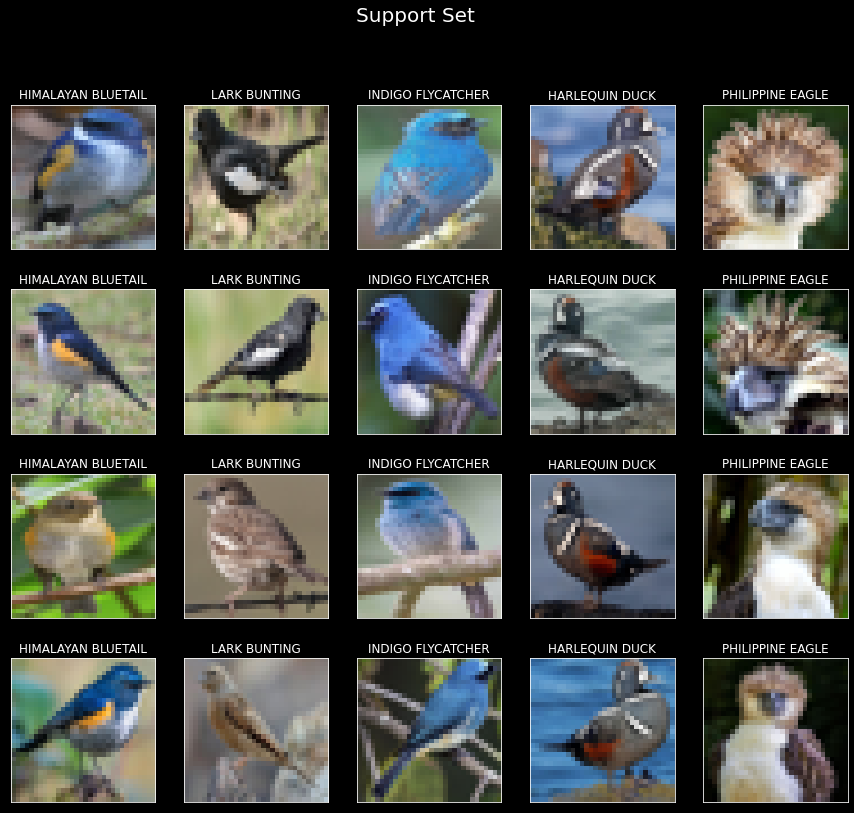

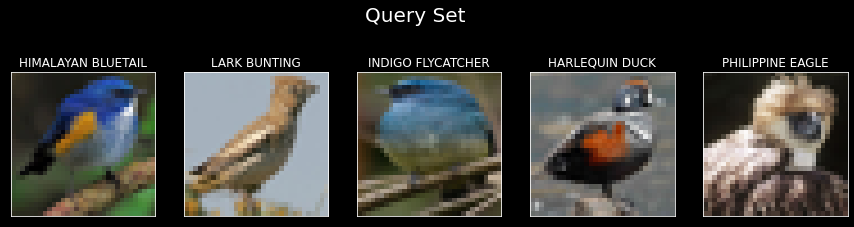

In [55]:
visualize_batch(*batch, id2cls)

In [56]:
[id2cls[i] for i in logits.argmax(axis=-1)]

['HIMALAYAN BLUETAIL',
 'LARK BUNTING',
 'HIMALAYAN BLUETAIL',
 'HARLEQUIN DUCK',
 'PHILIPPINE EAGLE']